In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [2]:
fps = (29.5)

def prepare_tables(table):
    first_body = table.bodyid[0]
    second_body = table.bodyid[1]
    first_body_table = table[table.bodyid == first_body]
    second_body_table = table[table.bodyid == second_body]
    return (first_body_table.to_dict(), second_body_table.to_dict())

def colours(which):
    if which:
        return ("limegreen", "darkgreen")
    return ("lightcoral", "darkred")

In [3]:
def plot_arr(chart, part_arr, colour):
    part_x = [x[0] for x in part_arr]
    part_y = [y[1] for y in part_arr]
    part_z = [z[2] for z in part_arr]
    chart.plot(xs=part_x, ys=part_y, zs=part_z, color=colour)

def str_to_array(string, dictable):
    import ast
    itm = dictable[string]
    all_pos = [None] * (len(itm) * 2)
    for k, v in itm.items():
        all_pos[k] = ast.literal_eval(v)
    return list(filter(
        lambda x: False if (x is None) or (x == [0,0,0]) else True,
        all_pos))

def coordinates_to_arr(coordinates):
    lr_arr = str_to_array("LeftHand", coordinates)
    dr_arr = str_to_array("RightHand", coordinates)
    return (lr_arr, dr_arr)

def draw_relevant(plotter, coordinates, scheme):
    sc_l, sc_r = colours(scheme)
    lr_arr, dr_arr = coordinates_to_arr(coordinates)
    plot_arr(ax1, lr_arr, sc_l)
    plot_arr(ax1, dr_arr, sc_r)

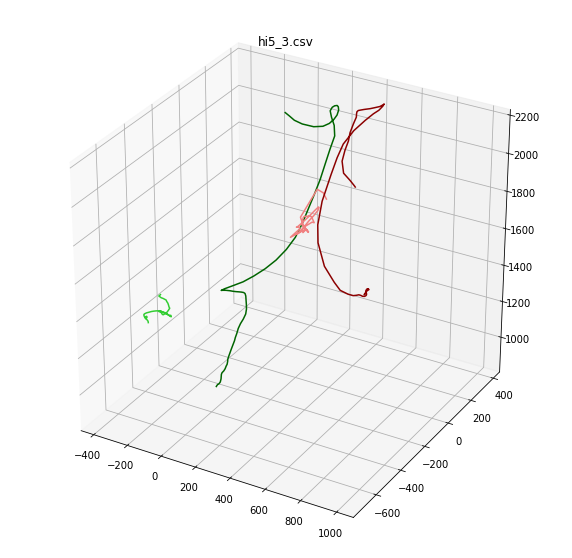

In [4]:
import os

%matplotlib inline

instances = []

list_of_files = os.listdir("csv_dataset")
list_of_files = [list_of_files[2]]

# For doing to all files
for file in list_of_files:
    table = pd.read_csv(os.path.join("csv_dataset", file))
    fst, snd = prepare_tables(table)
    
    instances.append( (
        coordinates_to_arr(fst),
        coordinates_to_arr(snd) )
    )
    
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.set_title(file)

    draw_relevant(ax1, fst, True)
    draw_relevant(ax1, snd, False)


iščemo najkrajšo razdaljo med krivuljami različnih barv

In [5]:
def euclidean_norm_sq(a, b):
    return (a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2

def euclidean_norm(a, b):
    return math.sqrt(euclidean_norm_sq(a,b))

def shortest_distance(first_body, second_body):
    dist = 99999999 # distances are only 1000ish apart
    for body_part1 in first_body:
        for body_part2 in second_body:
            for coor1 in body_part1:
                for coor2 in body_part2:
                    dist = min(dist, euclidean_norm_sq(coor1, coor2))
                    
    return dist


for (a,b) in instances:
    print(math.sqrt(shortest_distance(a,b)))

88.27920628324657


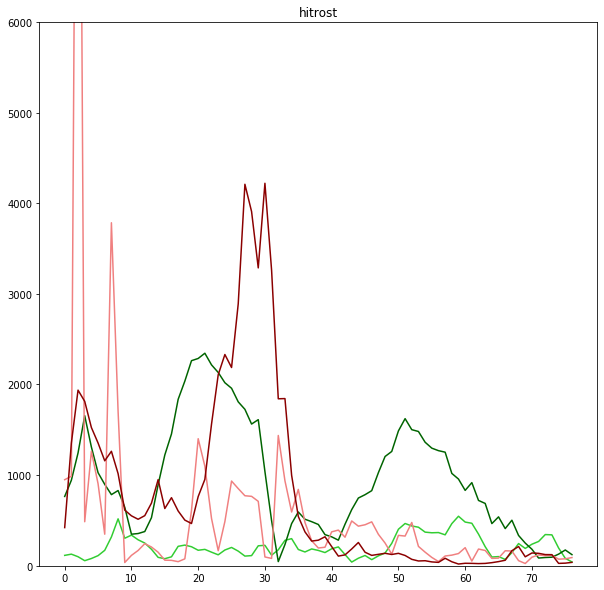

In [19]:
def iterate_pair(arr):
    i = 0
    while i < len(arr) - 1:
        yield (arr[i], arr[i+1])
        i += 1
        

def speed(body_part, fps):
    return [euclidean_norm(a,b) * fps for (a, b) in iterate_pair(body_part)]


for (a,b) in instances:
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    ax1.set_title("hitrost")
    ax1.set_ylim(-2, 6000)
    colour = lambda x: colours(True)[x]
    for i, body_part in enumerate(a):
        ax1.plot(speed(body_part, fps), color=colour(i))
    colour = lambda x: colours(False)[x]
    for i, body_part in enumerate(b):
        ax1.plot(speed(body_part, fps), color=colour(i))